In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import time
import datetime
import pandas
import numpy
import scipy.stats
import abcutils
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

## Global Analysis Constants

In [4]:
TEST_PLATFORMS = [
    'scratch1@edison',
#   'scratch2@edison',
    'scratch3@edison',
    'cscratch@cori-knl',
    'mira-fs1@mira'
]

## Load and Synthesize Data from CSV

In [5]:
filtered_df = abcutils.sc18paper.load_dataset()

Loading from cache cache.hdf5
Start with 14536 rows before filtering
Dropped 42 rows after filter #0 (14494 left)
Dropped 14 rows after filter #1 (14480 left)
Dropped 38 rows after filter #2 (14442 left)
Dropped 5 rows after filter #3 (14437 left)
Dropped 2451 rows after filter #4 (11986 left)
11986 rows remaining


## Global Correlation Table

Show the most compelling correlations across all data.  This will be messy because it includes all file systems and test conditions, so there are many uncontrolled variables represented.

In [6]:
pandas.options.display.max_rows = 40

correlation = abcutils.correlation.calc_correlation_vector(filtered_df, correlate_with='darshan_normalized_perf_by_max')

filtered_correlations = abcutils.apply_filters(correlation, [correlation['p-value'] < 1.0e-5], verbose=True)
filtered_correlations.sort_values('coefficient')

Start with 200 rows before filtering
Dropped 83 rows after filter #0 (117 left)
117 rows remaining


,coefficient,p-value
fs_monitoring_samples,-0.580476,2.111892e-202
darshan_walltime,-0.571585,0.000000e+00
jobsdb_concurrent_nodehrs,-0.532701,0.000000e+00
darshan_max_seq_reads_posix,-0.366307,0.000000e+00
darshan_min_seq_reads_posix,-0.366307,0.000000e+00
darshan_ave_seq_reads_posix,-0.366307,0.000000e+00
darshan_max_reads_posix,-0.345239,0.000000e+00
darshan_min_reads_posix,-0.345239,0.000000e+00
darshan_ave_reads_posix,-0.345239,0.000000e+00
fs_tot_ops,-0.325139,1.962086e-56


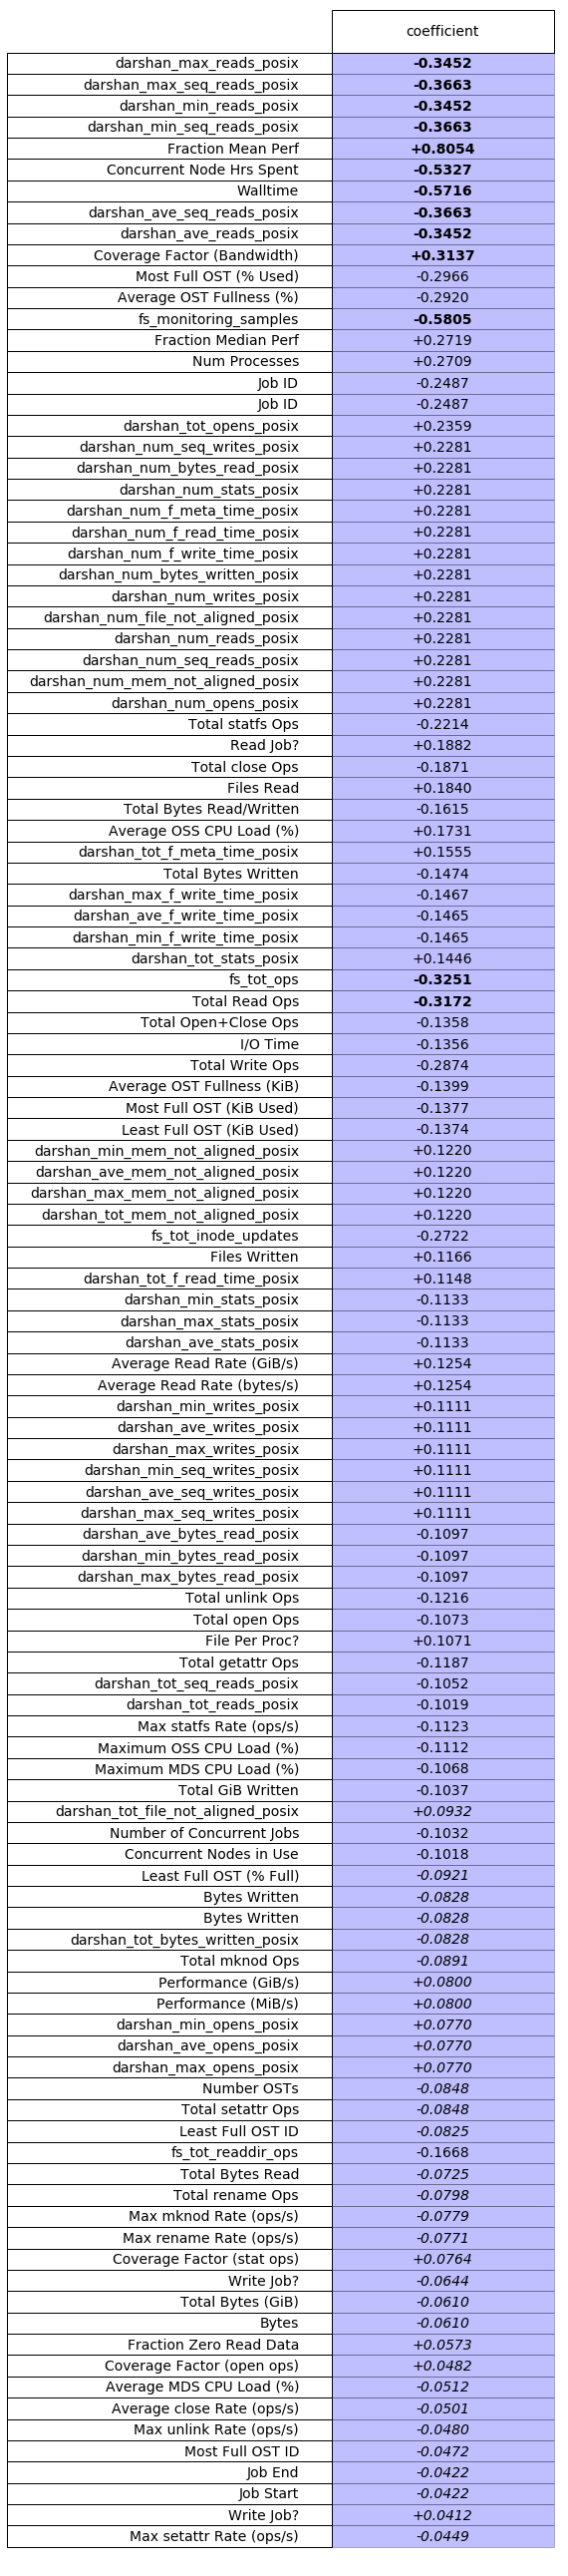

In [7]:
ax = abcutils.plot.correlation_vector_table(filtered_correlations, row_name_map=abcutils.CONFIG['metric_labels'])
ax.get_figure().set_size_inches(4, 0.4 * len(filtered_correlations))

Now draw the entire correlation table split out by _test platform_--a combination of the file system being tested and the node configuration being used to test it.

In [8]:
correlations = None
grouped_df = filtered_df.groupby('_test_platform')
for fs in TEST_PLATFORMS:
    # generate a single file system's correlation vector
    correlation = abcutils.correlation.calc_correlation_vector(
        grouped_df.get_group(fs),
        correlate_with='darshan_normalized_perf_by_max')
            
    # rename the columns in this vector to include the file system name
    new_cols = {}
    for index, col_name in enumerate(correlation.columns):
        new_cols[col_name] = "%s %s" % (fs, col_name)
    correlation.rename(columns=new_cols, inplace=True)
    
    # join the vector to the previous vectors' dataframe
    if correlations is None:
        correlations = correlation
    else:
        correlations = pandas.concat([correlations, correlation], axis='columns')

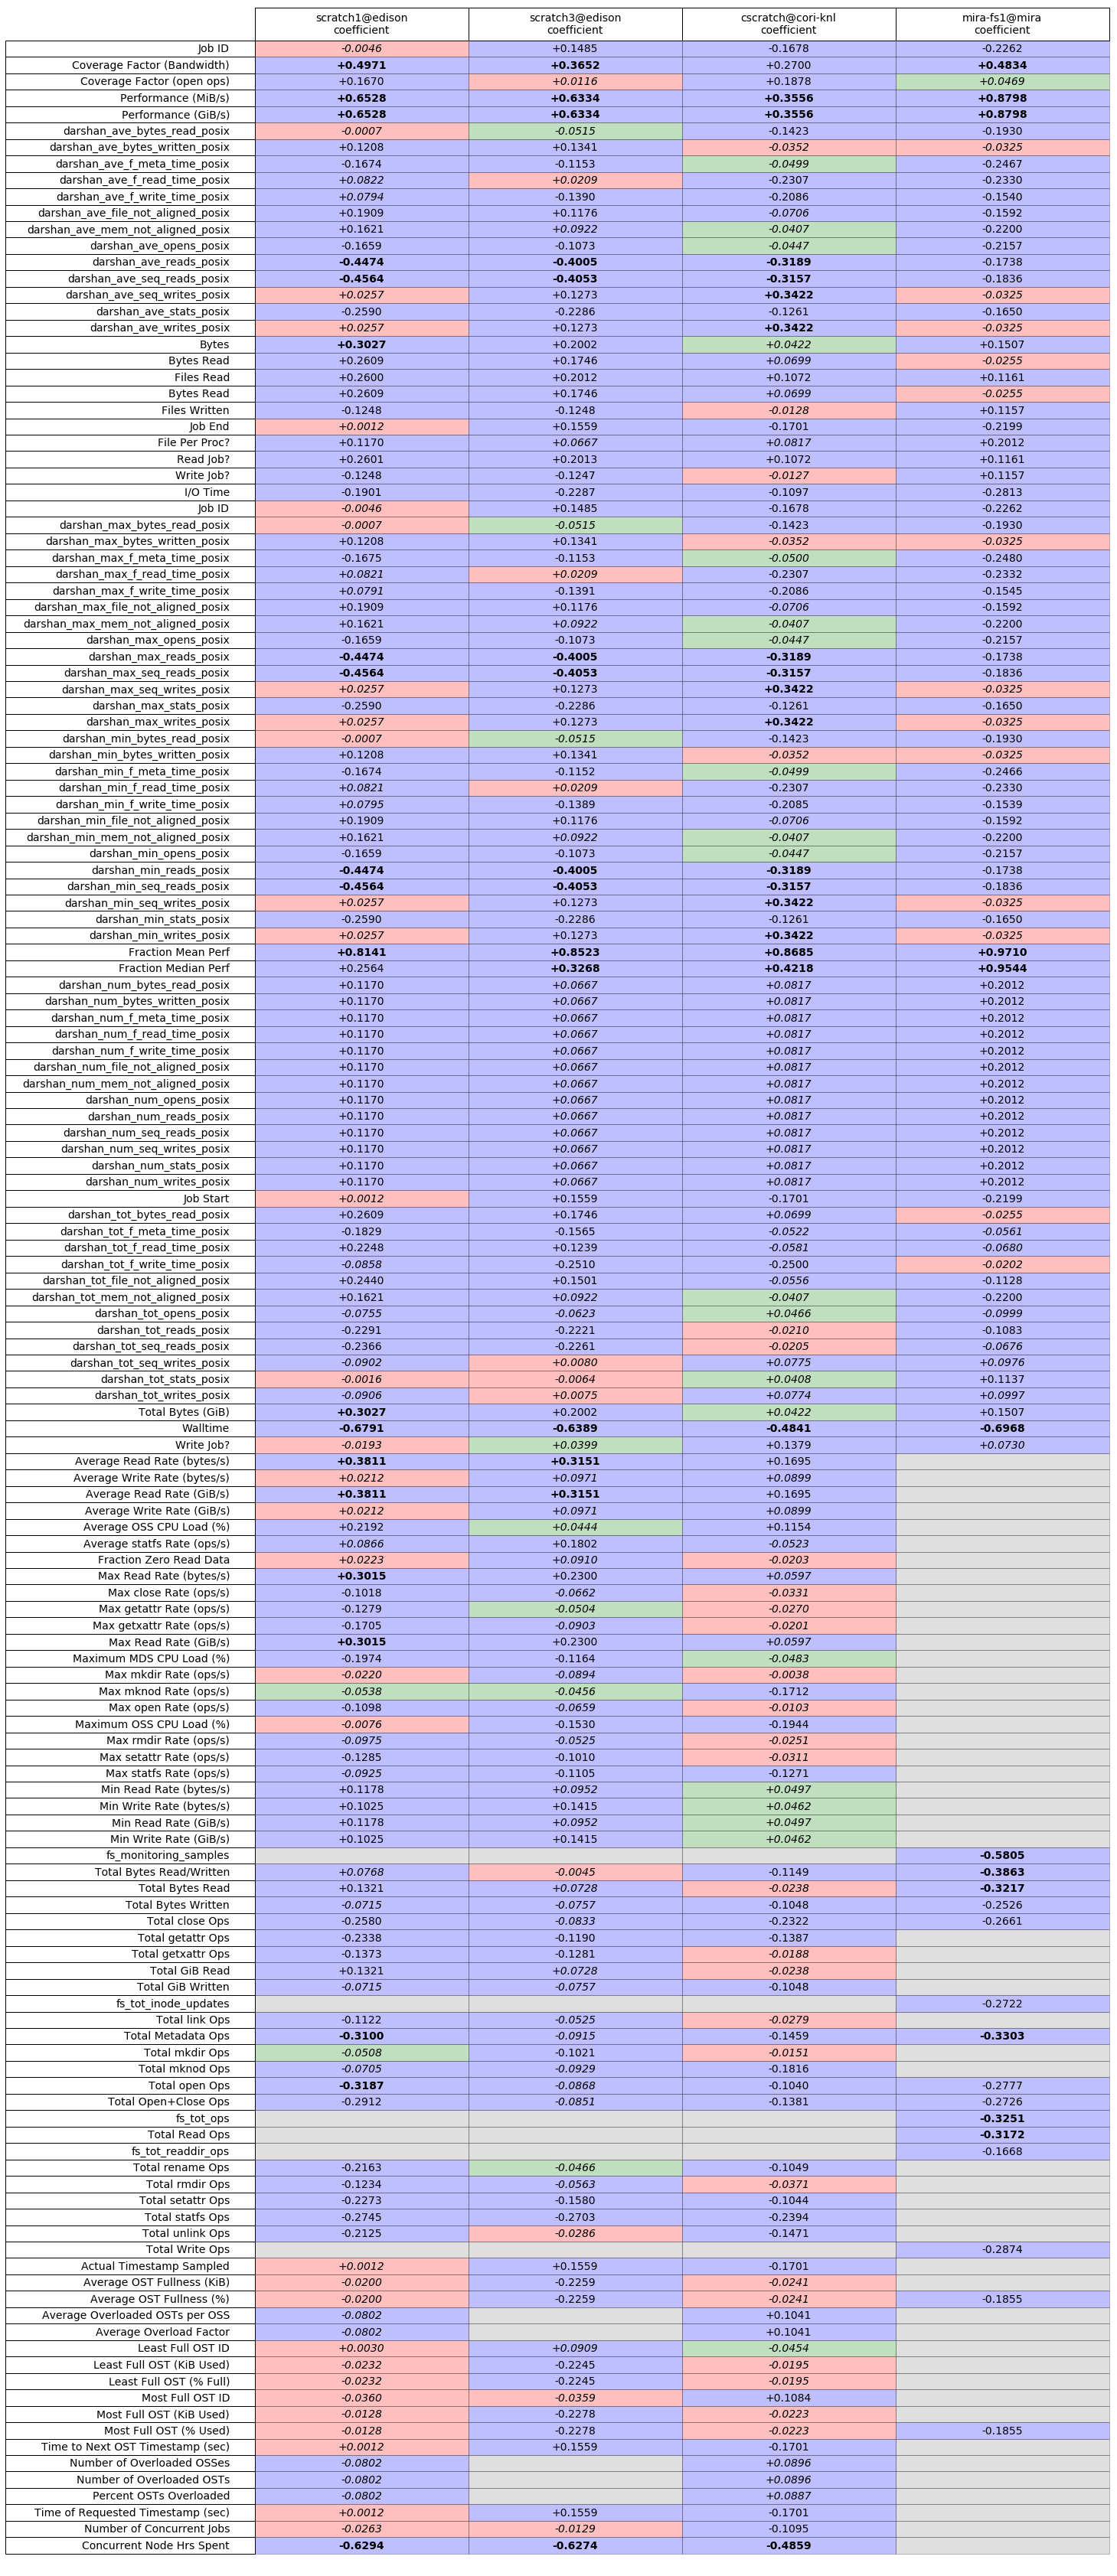

In [9]:
# Construct filter to show any metric that registered a low p-value for _any_ file system
filters = None
for fs in TEST_PLATFORMS:
    subfilter = correlations['%s p-value' % fs] < 1.0e-5
    if filters is None:
        filters = subfilter
    else:
        filters |= subfilter

ax = abcutils.plot.correlation_vector_table(
    correlations[filters],
    row_name_map=abcutils.CONFIG['metric_labels'])

# Set the table width larger if displaying lots of metrics
ax.get_figure().set_size_inches(20, 0.4 * len(correlations[filters]))